<h1><center>Mountain Car Problem</center></h1>

<h2><center>Part 1: Q-learning</center></h2>

<h3><center>Claudia Afonso</center><h3>

---

This first notebook contains the part of the project related with Q-learning. The second notebook contains the part of the project related with Deep Q-learning. The comparison between the two trained agents can be found in the second notebook at the end.

## 1. Introduction

The purpose of this project is to use two reinforcement learning approaches, namely Q-learning and deep reinforcement learning, to implement two distinct agents to solve the Mountain Car problem. The Mountain Car environment is provided by the OpenAI Gym (https://gymnasium.farama.org/) framework, now called Gymnasium. Here, an underpowered car must drive up the hill on the right until reaches the goal state. Since the car starts in the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction, and is subject to the laws of physics, it must build up enough momentum by accelerating back and forth across the hill to overcome gravity and reach the goal state on the top of the right hill. The .gif below was produced as a result of applying q-learning to the Car Mountain problem in this project.

<img src="car_qlearning.gif" width="700" align="center">

### 1.1. General Exploration of the Mountain Car Environment in Gymnasium

In [1]:
# Importing the required libraries
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import time
from matplotlib.patches import Patch
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')

In [2]:
# "Make" the environment, as in, instantiate an object with an environment of the Mountain Car Problem.
env = gym.make("MountainCar-v0", render_mode="rgb_array")

#### 1.1.1 Observation Space

The observation is a `ndarray` with shape (2,) where the elements correspond to the position of the car along the x-axis, bounded by the interval [-1.2, 0.6] and the velocity of the car, bounded by the interval [-0.07, 0.07].

In [3]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [4]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

In [5]:
print('The minimum position along the x-axis is:', env.observation_space.low[0])

The minimum position along the x-axis is: -1.2


In [6]:
print('The minimum velocity is:', env.observation_space.low[1])

The minimum velocity is: -0.07


In [7]:
print('The maximum position along the x-axis is:', env.observation_space.high[0])

The maximum position along the x-axis is: 0.6


In [8]:
print('The maximum velocity is:', env.observation_space.high[1])

The maximum velocity is: 0.07


Thus, in the Mountain Car problem, the (position, velocity) constitutes the state.

#### 1.1.2 Action Space

An agent interacts with an environment by observing the state and using this information to select an action. The environment accepts the action and transitions into the next state. It then returns the next state and a reward to the agent. In the Mountain Car problem, there are 3 discrete deterministic actions:

* 0: Accelerate to the left

* 1: Don’t accelerate

* 2: Accelerate to the right

In [9]:
env.action_space

Discrete(3)

#### 1.1.3 Reward

The agent explores the environment and receives rewards for its actions, which can then be used to estimate future rewards. In this environment, the goal is to reach the flag placed on top of the right hill as quickly as possible. As such, the agent is penalised with a reward of -1 for each (state &rarr; action &rarr; reward) cycle, which is also known as a timestep, if it is not at the goal state. If the agent is at the goal state, it receives a reward of 0.

In [10]:
env.reward_range

(-inf, inf)

#### 1.1.4 Starting State

The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.

In [11]:
env.reset()

(array([-0.46338746,  0.        ], dtype=float32), {})

#### 1.1.4 Episode End

The episode ends if either of the following happens:

* `Termination`: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
* `Truncation`: The length of the episode is 200.

It is possible to increase the length of the episodes by passing a more convenient value to `env._max_episode_steps`.

### 1.2 Key Definitions in Reinforcement Learning

Reinforcement learning algorithms involve estimating value functions, that is functions of states or of state-action pairs, that estimate how good it is for the agent to be in a given state or how good it is to perform a given action in a given state. This notion of "how good" is dfeined in terms of expected return.

#### 1.2.1. Policy

A policy $\pi$ is a mapping from states to probabilities of selecting each possible action.

#### 1.2.2. Value Function

The value function of a state $s$ under a policy $\pi$, denoted $v_\pi(s)$, is the expected return when starting in *s* and following $\pi$ thereafter. The value of the terminal state, if any, is always zero.

#### 1.2.3. Action Value Function (Q-Function)

The state-value function of taking action *a* in state *s* under policy $\pi$, denoted $q_{\pi}(s,a)$ is the expected return starting from *s*, taking the action *a*, and thereafter following policy $\pi$.

#### 1.2.4. Optimal Policies and Optimal Value Functions

* Optimal Policy, $\pi_{opt}$, is the one whose expected return is greater than or equal to that of all other policies for all states. The optimal policies share the same optimal value function, $V_{opt}(s)$, and the same optimal action value function, $Q_{opt}(s,a)$.
<br>

* Optimal Value Function, $V_{opt}(s)$, gives the expected return by following an optimal policy $\pi_{opt}$ from state *s*. In other words, it is the maximum return attained by any policy in state *s*.
<br>

* Optimal Action Value Function, $Q_{opt}(s,a)$, gives the expected return for taking action a in state s and thereafter following an optimal policy  $\pi_{opt}$.

## 2. Training an agent with Q-learning

### 2.1. Q-learning

Q-learning is a model-free algorithm, that is, it relies on learning by trial and error the action value function without the requiring explicit knowledge of the underlying transition probabilities and rewards. In this off-policy temporal-difference algorithm, the learned action-value function, $Q(s,a)$, directly approximates the optimal action-value function, $Q_{opt}(s,a)$, independent of the policy being followed. The implementation of Q-learning typically uses a look-up table representation of the Q-values, $Q(s,a)$, which is known as the Q-table where each entry represents the estimated Q-value for a given state-action pair. The Q-learning update rule is the following:

<br>
<center>$Q(s,a) = Q(s,a) + \alpha (r + \gamma \max_{a'} Q(s',a') - Q(s,a))$</center>
<br>

where $\alpha$ is the learning rate and $\gamma$ is the discount factor which reflects the fact that a reward might be worth more in the present than in the future.


Q-learning is a model-free algorithm, that is, it relies on learning by trial and error the optimal policy or action-values from interacting with the environment without the requiring explicit knowledge of the underlying transition probabilities and rewards. 



A requirement for convergence to occur in Q-learning is that all admissible state-action pairs should be explored a significant amount of times. To accomplish this, Q-learning balances exploration with exploitation by using the $\epsilon$-greeedy algorithm:

<br>
<center>
  $\pi_a(s)=\left\{
    \begin{array}{ll}
      \text{argmax} \:\hat{Q}_{opt}(s,a), & \mbox{probability $1-\epsilon$}\\
      \text{random from Actions(s)}, & \mbox{probability $\epsilon$}
    \end{array}
  \right.$


Once the optimal Q-values are computed, the optimal policy is determined using the following equation:

<br>
<center>$\pi_{opt}(s) = \text{argmax} \: Q_{opt}(s,a) $</center>
<br>
   
    
The pseudocode for implementing the Q-learning algorithm is the following:

<img src="Pseudocode_Qlearning.jpg" width="500" height="340"/>

### 2.2. Applying Q-learning to the Mountain Car problem

#### 2.2.1 Discretizing the position and velocity of the observation space

The Mountain Car problem has a bounded continuous observation space. If one were to build a Q-table from the cartesian product of the observation dimensions, it would virtually infinite as the positon and velocity of the car are continuous. However, as it is a bounded space, it is possible to discretize it in order to build a Q-table that is more manageable. Thus, the following function was created to discretize the observation space into equal size intervals.

In [12]:
def space_discretization(env, num_intervals):
    
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_intervals)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_intervals)
    
    return pos_space, vel_space

In [13]:
# Discretizing the space into 20 by 20 intervals
pos_space, vel_space = space_discretization(env, 20)

# Initializing the Q-table (the Q value of all state-action pairs) to 0
Q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))
Q.shape

(20, 20, 3)

It is also necessary to define a function that returns the discretized position and velocity of the car following a given action.

In [14]:
def get_discretized_observation(env, observation, num_intervals):
    
    pos, vel = observation
    
    pos_space, vel_space = space_discretization(env, num_intervals)
    
    pos = np.digitize(observation[0], pos_space)
    vel = np.digitize(observation[1], vel_space)
    
    return pos, vel

#### 2.2.2 Implementing the $\epsilon$-greedy algorithm

Since exploration needs to be balanced with exploitation in Q-learning, the $\epsilon$-greedy algorithm was implemented. In addition, a linear epsilon decay as the epsidoes evolve was also incorporated into our Q-learning implementation. By setting $\epsilon$ high in the beginning of the training, the agent is more likely to explore the environment (and thus, estimate values for state-action pairs) rather than pick the best known action. As the training evolves (that is, as the number of episodes increases), the $\epsilon$ value decreases. In turn, the agent shifts from a mostly exploration-based behaviour to a more exploitation-heavy behaviour in which it relies on its learned knowledge (that is, the action value function) to pick the best action.

In [15]:
def epsilon_greedy(pos, vel, epsilon, qtable):
    
    if random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(qtable[pos, vel, :])

In [16]:
def epsilon_decay(epsilon_init, min_epsilon, num_episodes, episode):
    
    return (epsilon_init - min_epsilon) * max((num_episodes - episode) / num_episodes, 0) + min_epsilon

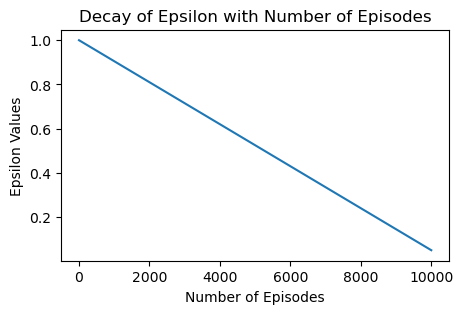

In [17]:
epsilon_init = 1 # 1 = 100% random actions
min_epsilon = 0.05
num_episodes = 10000
epsilons = np.zeros(num_episodes)
for episode in range(num_episodes):
    epsilons[episode] = epsilon_decay(epsilon_init, min_epsilon, num_episodes, episode)

# Creating a plot to show the decay of epsilon as the number of episodes increases
fig = plt.figure(figsize=(5, 3))
plt.plot(range(num_episodes), epsilons)

plt.xlabel('Number of Episodes')
plt.ylabel('Epsilon Values')
plt.title('Decay of Epsilon with Number of Episodes')

# Display the plot
plt.show()

#### 2.2.2 Computing the optimal policy using Q-learning 

Several simple functions were developed to visualize the plots from the trained agents.

In [18]:
def plot_rewards(rewards):
    
    fig = plt.figure(figsize=(15, 4))
    
    plt.plot(rewards)
    plt.xlabel('Number of Episodes')
    plt.ylabel(f'Rewards')
    plt.title(f'Rewards as a function of the Number of Episodes')
    plt.show()

In [19]:
def plot_average_rewards(rewards, interval):
    
    avg_rewards = np.zeros(len(rewards))
    for i in range(len(rewards)):
        avg_rewards[i] = np.mean(rewards[max(0, i-interval):i+1])
        
    fig = plt.figure(figsize=(15, 4))
    plt.plot(avg_rewards)
    plt.xlabel('Number of Episodes')
    plt.ylabel(f'Average of Rewards')
    plt.title(f'Average of Rewards (over the last {interval} episodes) as a function of the Number of Episodes')
    plt.show()

In [20]:
def plot_steps(steps):
    
    fig = plt.figure(figsize=(15, 4))
    
    plt.plot(steps)
    plt.xlabel('Number of Episodes')
    plt.ylabel(f'Steps')
    plt.title(f'Steps as a function of the Number of Episodes')
    plt.show()

In [21]:
def plot_average_steps(steps, interval):
    
    avg_steps = np.zeros(len(steps))
    for i in range(len(steps)):
        avg_steps[i] = np.mean(steps[max(0, i-interval):i+1])
        
    fig = plt.figure(figsize=(15, 4))
    plt.plot(avg_steps)
    plt.xlabel('Number of Episodes')
    plt.ylabel(f'Average of Steps')
    plt.title(f'Average of Steps (over the last {interval} episodes) as a function of the Number of Episodes')
    plt.show()

Our implementation of the Q-learning follows the pseudocode shown earlier, which also corresponds to the implementation shown in class. One iteration of Mountain Car consists of 200 time steps. However, this pre-defined number of steps was changed to become equal to the num_steps parameter. This was done because in the environment gives a reward of -1 for each step the agent takes. Since there isn't a positive reinforcement during the training (the agent only receives a positive reward if it reaches the goal), the agent is unlikely to reach the goal in only 200 steps and thus learn a policy in a single episode. Since in this case the num_steps was changed, the average return for a random policy is not equal to -200, but instead equal to -num_steps.

In [22]:
def qlearning(num_episodes, num_steps, alpha, gamma, epsilon_init, min_epsilon, num_intervals):
    
    # Initialize the environment
    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    
    # Discretizing the space into 20 by 20 intervals
    pos_space, vel_space = space_discretization(env, num_intervals)

    # Initializing the Q-table (the Q value of all state-action pairs) to 0
    Q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))
    
    # Setting the number of steps in each episode
    env._max_episode_steps = num_steps
    
    # Initializing the rewards of all episodes to 0s
    #rewards_per_episode = np.zeros(num_episodes)
    rewards_per_episode = np.array([])
    
    # Initializing the number of steps of all episodes to 0s
    #steps_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.array([]) 
    
    # Setting the epsilon to its initial value
    epsilon = epsilon_init
    
    # Setting the goal of reaching the flag to False in the beggining
    goal = False
    
    # Defining a minimum average reward goal
    min_avg_reward = -110
    
    # Start counting the time
    start_time = time.time()

    # For each episode:
    for episode in range(num_episodes):
                
        # Initializing the state by resetting the environment
        s, _ = env.reset()      # Starting position, starting velocity always 0
        
        # Allocating the position and velocity at the start to one of the discretized values of the observation space
        p, v = get_discretized_observation(env, s, num_intervals)
        
        # At the beginning, no rewards have been collected
        rewards = 0
        
        # For each step in the episode
        for step in range(num_steps):
            
            # Select the action using the epsilon-greedy
            a = epsilon_greedy(p,v,epsilon, Q)
            
            # Perform the selected action and store the next state information
            s_, r, done, _, _ = env.step(a)
            
            p_, v_ = get_discretized_observation(env,s_,num_intervals)
            
            # Select the action a_ which has a maximum Q value in the next state
            a_ = np.argmax(Q[p_,v_,:])
            
            # Calculate the Q value of previous state using our update rule
            Q[p,v,a] = Q[p,v,a] + alpha*(r + gamma*Q[p_,v_,a_] - Q[p,v,a])
            
            # Update current state to next state
            p = p_
            v = v_
            
            # Add the reward
            rewards += r
            
            # If the current state is the terminal state then store the frame and break
            if done:
                goal = True
                goal_frame = env.render()
                break
                
        # Epsilon decay
        epsilon = epsilon_decay(epsilon_init, min_epsilon, num_episodes, episode)
        
        # Adding the rewards of each episode        
        #rewards_per_episode[episode] = rewards        
        rewards_per_episode = np.append(rewards_per_episode, rewards)
        
        # Adding the steps of each episode (adding one because the range starts from 0)
        #steps_per_episode[episode] = step + 1
        steps_per_episode = np.append(steps_per_episode, step+1)
        
        # Print the number of episodes it took for the mountain car to be solved
        # MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials.
        if np.mean(rewards_per_episode[-100:]) >= min_avg_reward:
            print(np.mean(rewards_per_episode[-100:]))
            print(f'The Mountain Car problem has been solved at episode {episode+1} with an of epsilon {epsilon}!')
            print(f'It achieved an average reward of {np.mean(rewards_per_episode[-100:])} over the last 100 consecutive episodes')
            print(f'The average number of steps in the last 100 consecutive episodes was {np.mean(steps_per_episode[-100:])}')
    
    # Stop counting the time
    end_time = time.time()
    total_time = end_time - start_time
    minutes = total_time // 60
    seconds = total_time % 60
    seconds = round(seconds, 2)
    
    # Closing the environment
    env.close()
    
    # If the goal is reached, then the frame is shown
    if goal:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(goal_frame)
        plt.axis('off')
        plt.show()
        
    print(f'It achieved an average reward of {np.mean(rewards_per_episode[-100:])} over the last 100 consecutive episodes.')
    print(f'The average number of steps in the last 100 consecutive episodes was {np.mean(steps_per_episode[-100:])}.')
    print(f'This training took {minutes} minutes and {seconds} seconds.')

    return Q, rewards_per_episode, steps_per_episode

The Q-learning algorithm implemented here was used to train four agents using different numbers of space discretization (20, 100, 150 and 200).

**2.2.2.1 Agent 1: Testing with $\alpha$ = 0.9, $\gamma$ = 0.9 and $\epsilon$ = 1**

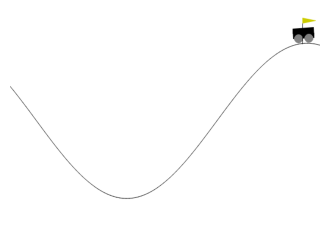

It achieved an average reward of -578.7 over the last 100 consecutive episodes.
The average number of steps in the last 100 consecutive episodes was 578.7.
This training took 14.0 minutes and 0.79 seconds.


In [23]:
qtable_1, rewards_per_episode_1, steps_per_episode_1 = qlearning(10000, 1000, 0.9, 0.9, 1, 0.05, 20)

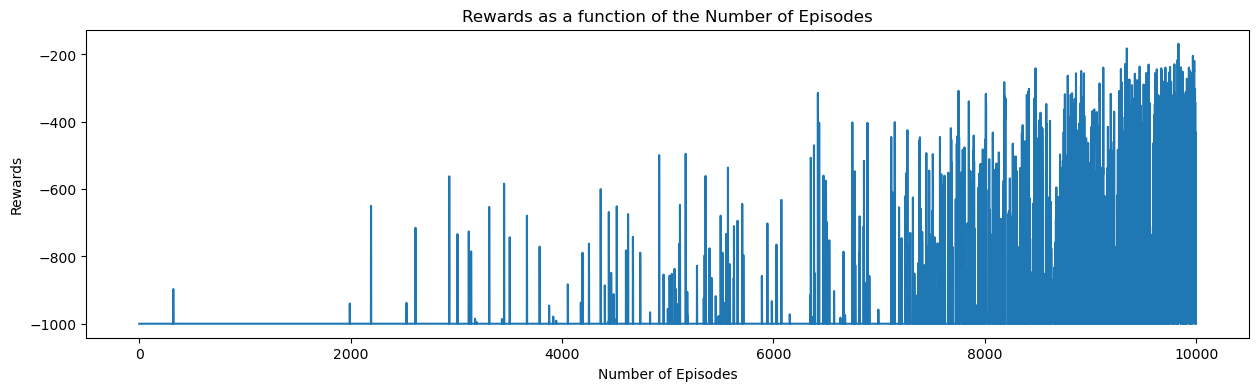

In [24]:
plot_rewards(rewards_per_episode_1)

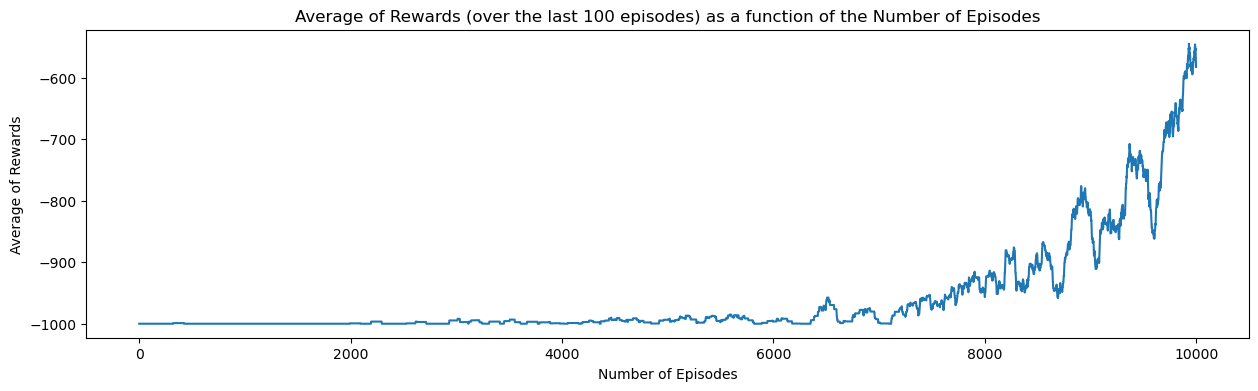

In [25]:
plot_average_rewards(rewards_per_episode_1, 100)

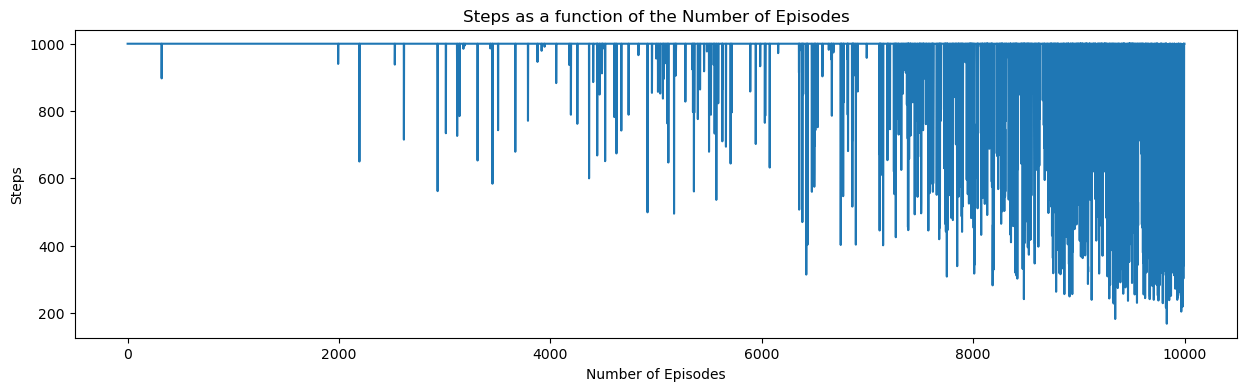

In [26]:
plot_steps(steps_per_episode_1)

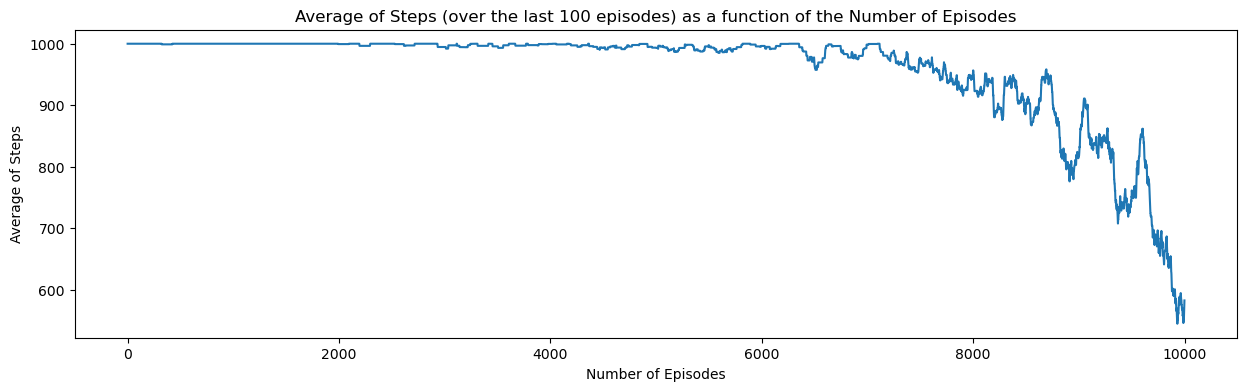

In [27]:
plot_average_steps(steps_per_episode_1, 100)

**2.2.2.2 Agent 2: Testing with $\alpha$ = 0.9, $\gamma$ = 0.9, $\epsilon$ = 1 and a discretization of 100 intervals in both space dimensions**

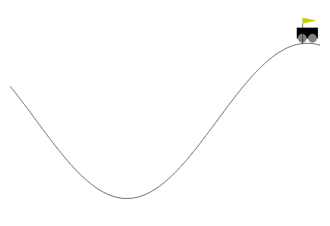

It achieved an average reward of -182.06 over the last 100 consecutive episodes.
The average number of steps in the last 100 consecutive episodes was 182.06.
This training took 8.0 minutes and 14.72 seconds.


In [28]:
qtable_2, rewards_per_episode_2, steps_per_episode_2 = qlearning(10000, 1000, 0.9, 0.9, 1, 0.05, 100)

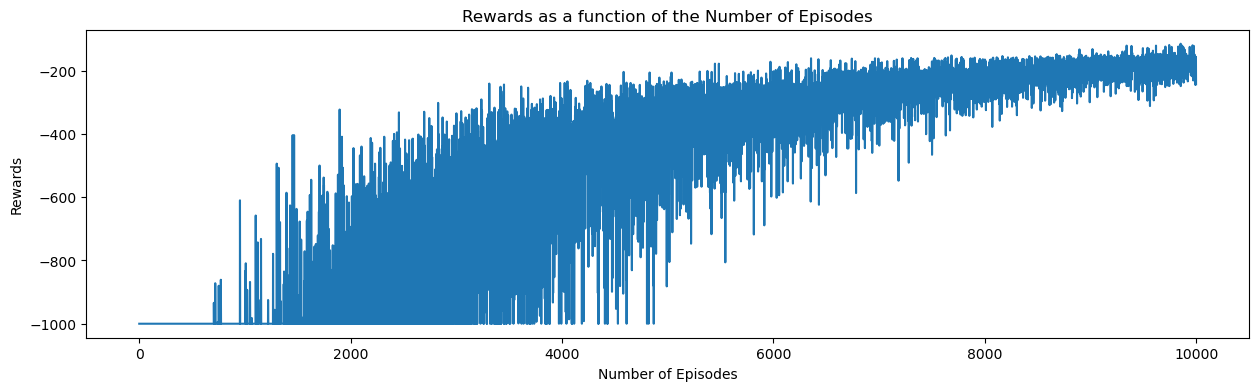

In [29]:
plot_rewards(rewards_per_episode_2)

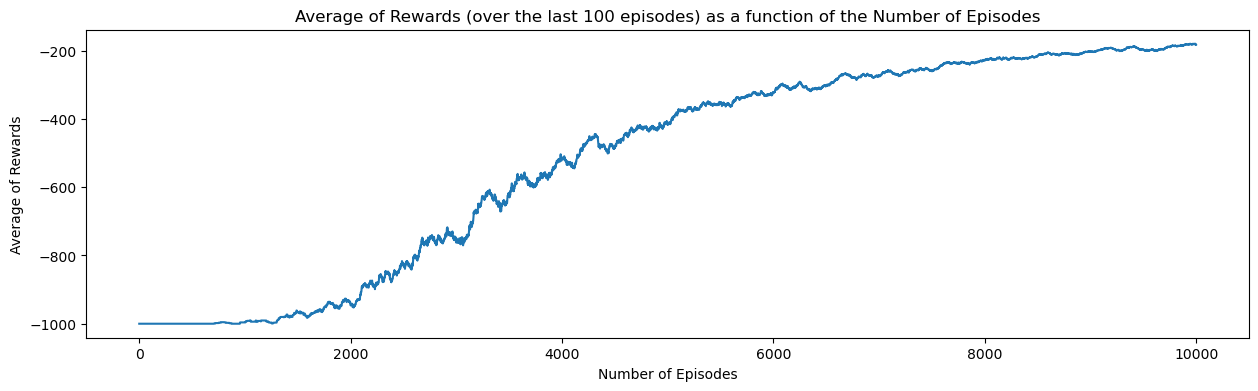

In [30]:
plot_average_rewards(rewards_per_episode_2, 100)

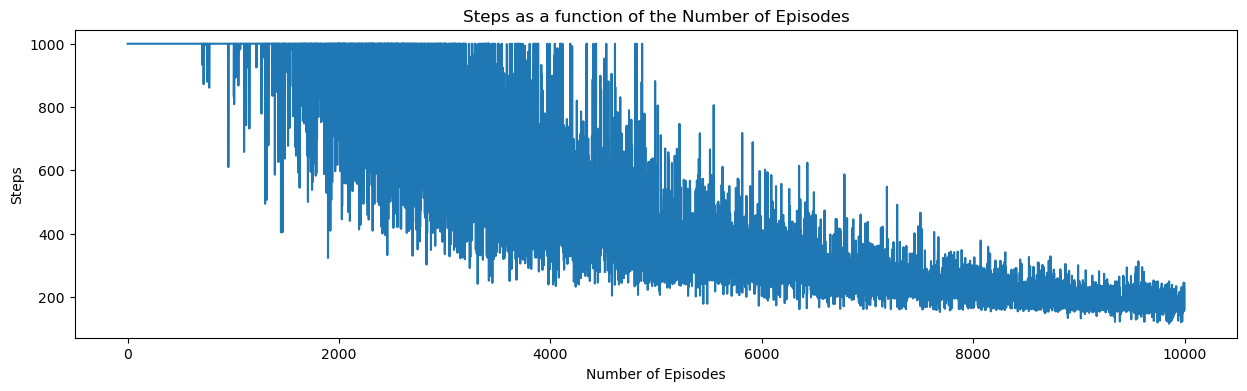

In [31]:
plot_steps(steps_per_episode_2)

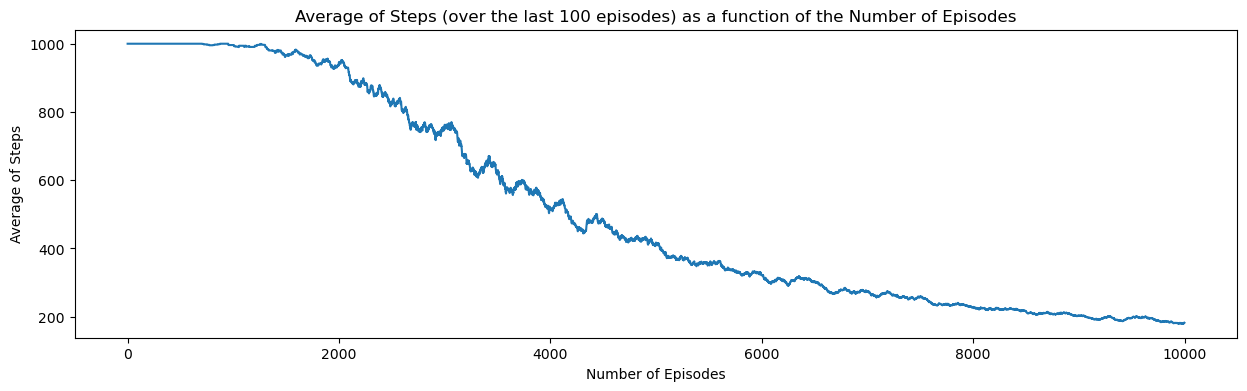

In [32]:
plot_average_steps(steps_per_episode_2, 100)

**2.2.2.3 Agent 3: Testing with $\alpha$ = 0.9, $\gamma$ = 0.9, $\epsilon$ = 1, a discretization of 150 intervals in both space dimensions**

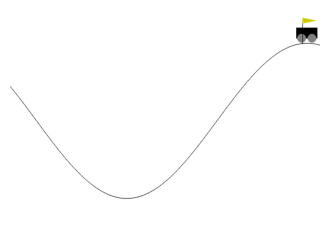

It achieved an average reward of -160.94 over the last 100 consecutive episodes.
The average number of steps in the last 100 consecutive episodes was 160.94.
This training took 7.0 minutes and 58.11 seconds.


In [33]:
qtable_3, rewards_per_episode_3, steps_per_episode_3 = qlearning(10000, 1000, 0.9, 0.9, 1, 0.05, 150)

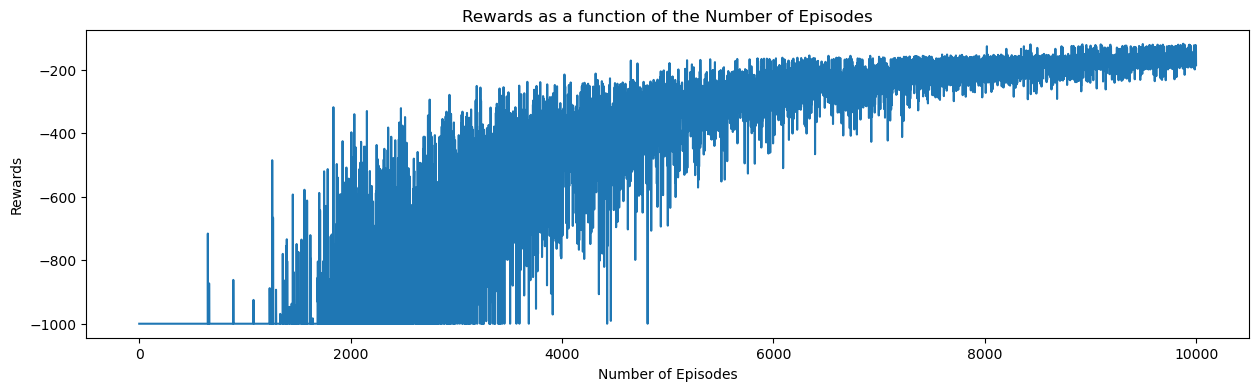

In [34]:
plot_rewards(rewards_per_episode_3)

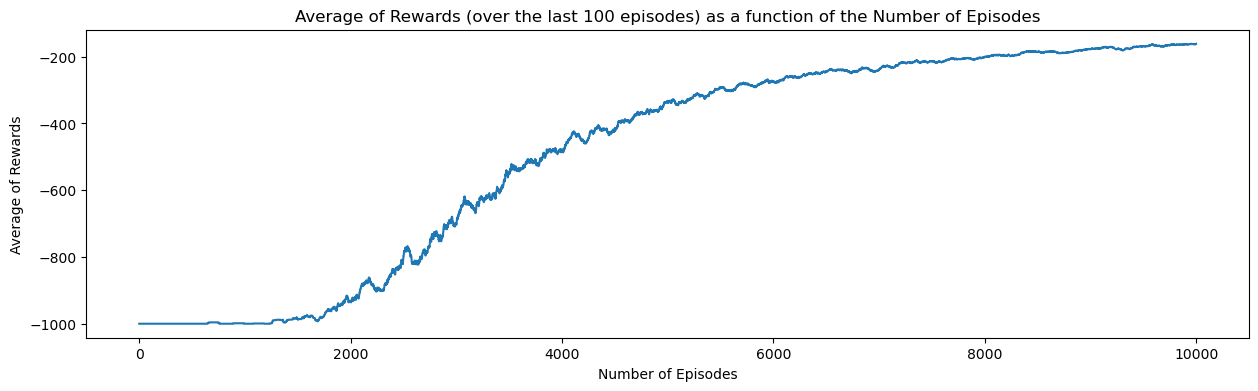

In [35]:
plot_average_rewards(rewards_per_episode_3, 100)

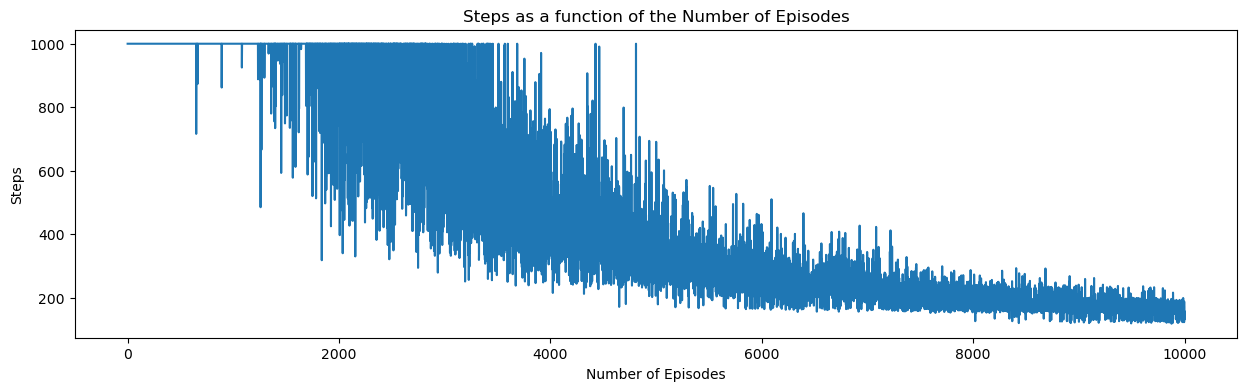

In [36]:
plot_steps(steps_per_episode_3)

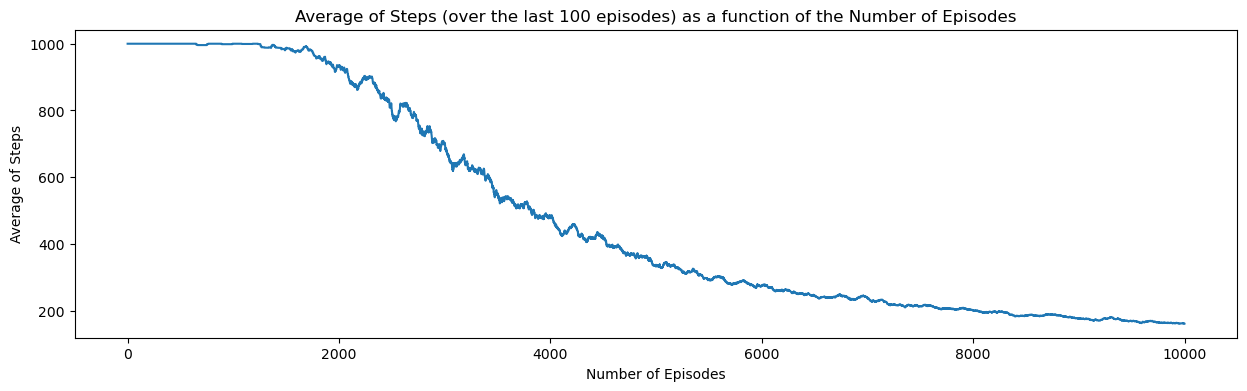

In [37]:
plot_average_steps(steps_per_episode_3, 100)

**2.2.2.3 Agent 4: Testing with $\alpha$ = 0.9, $\gamma$ = 0.9, $\epsilon$ = 1, a discretization of 200 intervals in both space dimensions**

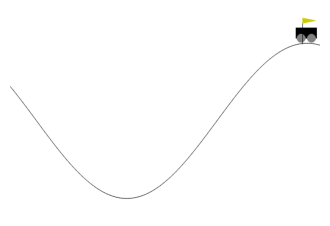

It achieved an average reward of -203.88 over the last 100 consecutive episodes.
The average number of steps in the last 100 consecutive episodes was 203.88.
This training took 8.0 minutes and 12.13 seconds.


In [38]:
qtable_4, rewards_per_episode_4, steps_per_episode_4 = qlearning(10000, 1000, 0.9, 0.9, 1, 0.05, 200)

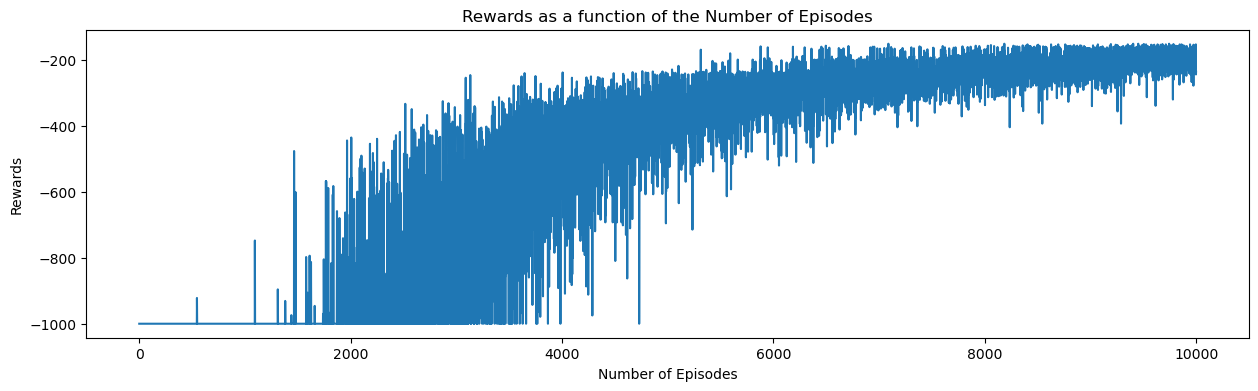

In [39]:
plot_rewards(rewards_per_episode_4)

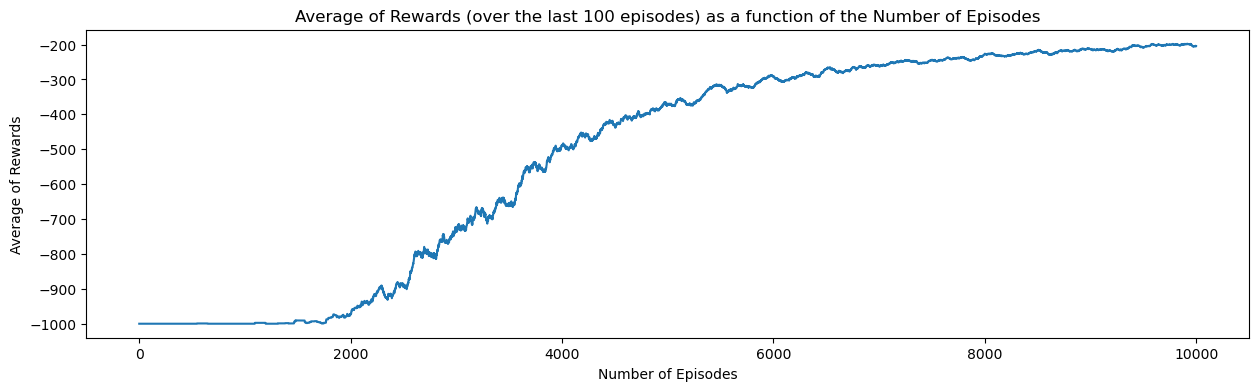

In [40]:
plot_average_rewards(rewards_per_episode_4, 100)

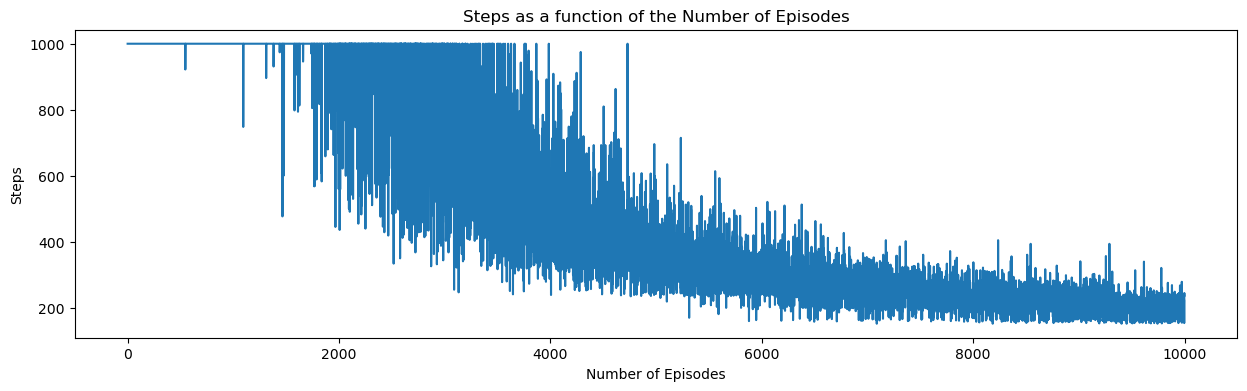

In [41]:
plot_steps(steps_per_episode_4)

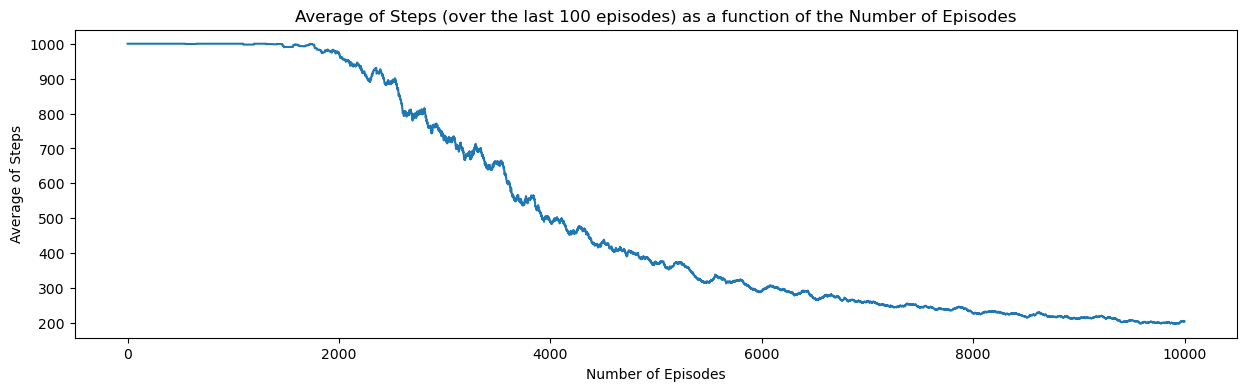

In [42]:
plot_average_steps(steps_per_episode_4, 100)

As observed, it took longest to train when the number of intervals for space discretization was lowest (specifically, 20 in each dimension: position and velocity). While surprising at first (since it would be expected that training would take less time when space discretization is lowest), this might be due to the fact that the agent needs to perform more steps to learn and reach its goal when the number of space intervals is too low. Thus, in this case the "for step in range(num_steps)" loop will run many more times when compared with the other tested cases where the number of discrete space intervals is higher.

Looking at the plots, it is possible to see that as the number of episodes increases, the rewards and its average over the last 100 episodes decreases until it stabilizes at approximately -200 (this varies for each trained agent). This decrease starts to occur at approximately 2000 episodes. With the opposite trend, the number of steps the agent needs to take to reach its goal decreases as the episodes evolve. This phenomenon is due to the decay in the epsilon parameter as the episodes evolve. That is, the agent changes its behaviour going from a mostly exploration-based to a more exploitation-heavy one. By taking advantage of its learned knowledge, that is, the estimated action value function, $\hat{Q}(s,a)$, the agent is able to finally reach its goal in a lesser number of steps.

MountainCar-v0 is typically considered solved when the average reward over 100 consecutive trials is -110.0 (https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0). In the four agents trained here, this score was not reached just by increasing space discretization. Thus, to achieve this, perhaps other parameters would have to be tuned. In addition, other decaying functions for epsilon could be used. Still, at approximately -160.94, the value of the average reward for `Agent 3` was quite acceptable and allowed us to obtain an approximation to the optimal policy. Here, the functions `extract_policy` and `plot_policy` were developed. As mentioned, the approximated optimal policy was extracted from the trained agent that showed the highest average reward over its last 100 consecutive episodes, which was `Agent 3`.

In [43]:
def extract_policy(qtable):
    
    return np.argmax(qtable, axis=2)

In [44]:
def plot_policy(policy):
    
    # Create a custom legend
    legend_labels = {0: 'Accelerate to the left', 1: "Don’t accelerate", 2: 'Accelerate to the right'}

    # Create a colormap
    cmap = sns.color_palette("Blues", n_colors=3)

    fig = plt.figure(figsize=(15, 15))

    # Create a heatmap using the 'Blues' colormap
    sns.heatmap(policy, cmap=cmap, linewidths=.5, square=True, cbar=False)

    # Add labels and title
    plt.xlabel('Velocity')
    plt.ylabel('Position')

    # Create a legend with color patches
    legend_patches = [Patch(color=cmap[i], label=label) for i, label in legend_labels.items()]

    plt.legend(handles=legend_patches, title=None, loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.show()

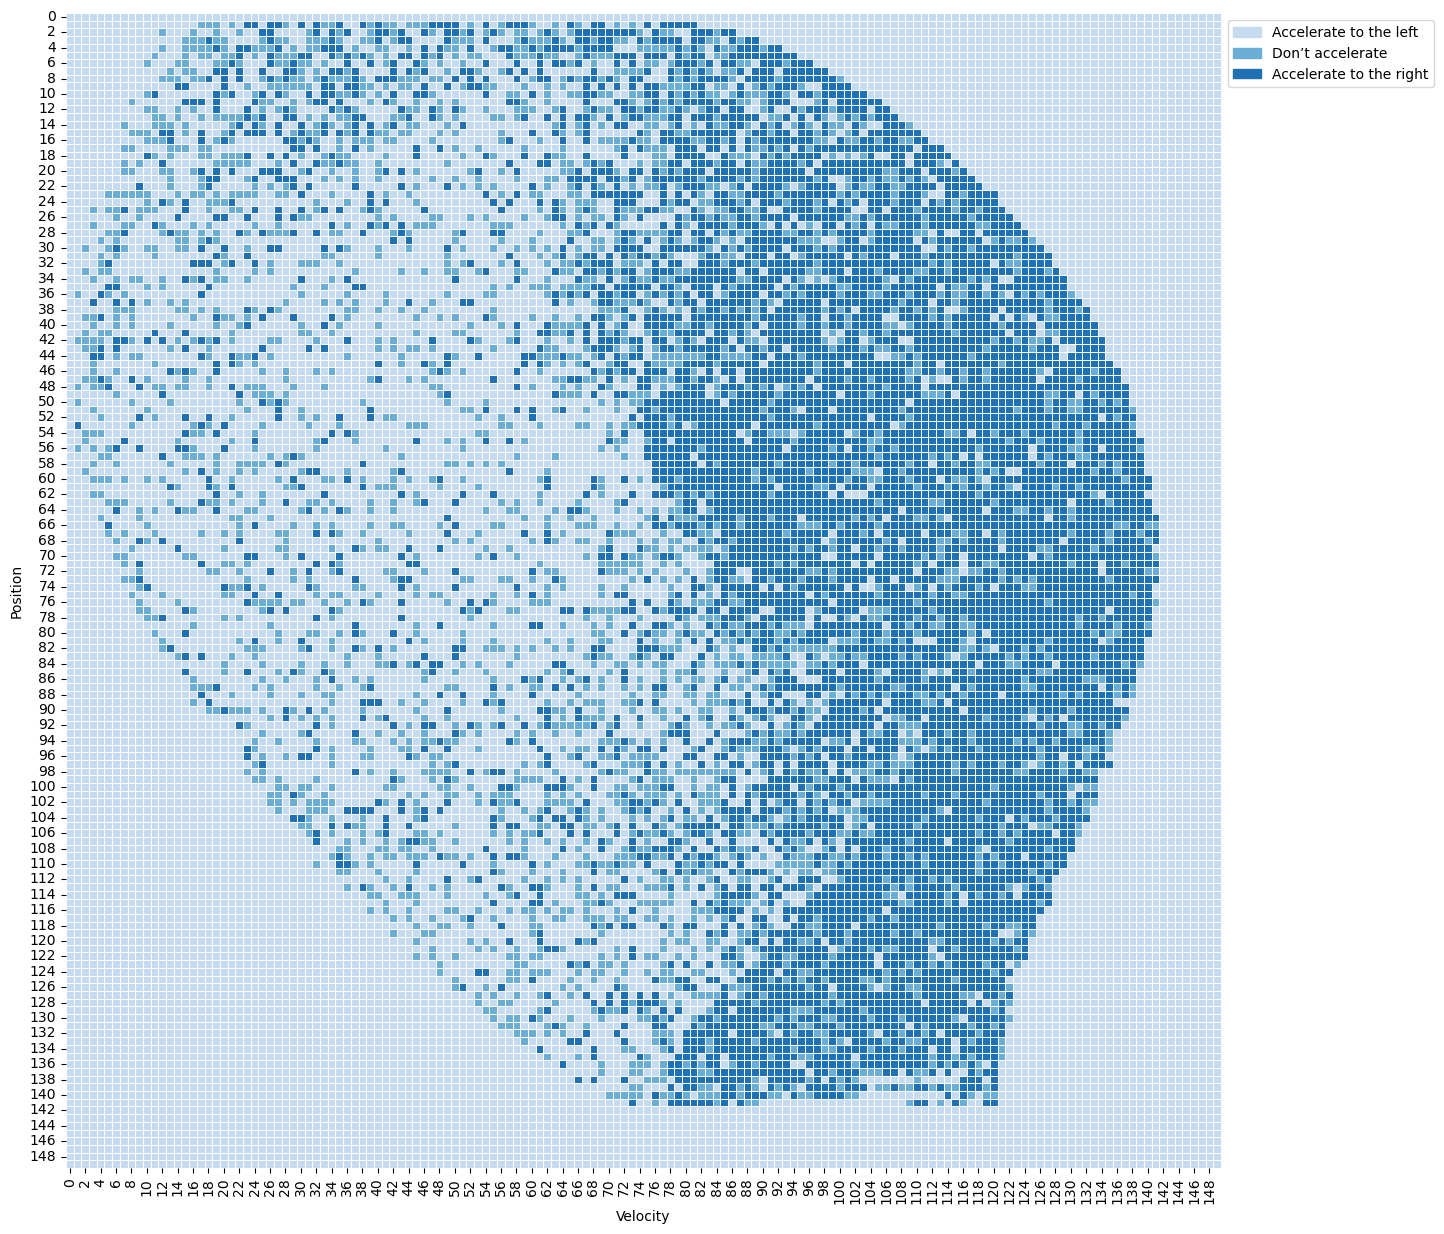

In [45]:
best_policy = extract_policy(qtable_3)
plot_policy(best_policy)

The best approximation to the optimal policy achieved for the Mountain Car problem (under the conditions tested in the context of this project) is shown in the Q-table above. Considering the entire Q-table irrespective of the positon or velocity of the agent, the action that appears the most is the `Accelerate to the Left`. The second most common action is `Accelerate to the Right` while `Don't accelerate` is the least likely action for the agent to pick. While counter-intuitive at first, the optimal policy appears to consist of doing the opposite action in regards to the position of the car. So, for instance, if the car is on the right hill (that is, higher values in the y-axis corresponding to the position dimension), then the best course of action would most likely be to accelerate to the left. Meanwhile, if the car is on the left hill (that is, lower values in the y-axis corresponding to the position dimension), then the most likely action to be picked would be to accelerate to the right. Interestingly, in both cases the most likely action would depend on the velocity of the car. For example, if the car on the right hill and if its velocity is relatively low, then the agent is more likely to accelerate to the left, whereas if its velocity is relatively high, then it is more likely to accelerate to the right. The same action decision according to the car's velocity occur when the agent is positioned on the left hill. This can be interpreted as the car taking advantage of rolling down the hills (aided by gravity as well) to build momentum that is sufficient to later climb the right hill. Thus, if the velocity of the car is not enough to overcome the gravitational pull and thus climb the right hill, then the best action would be to accelerate in the opposite direction so as to build enough momentum in the subsequent cycle. In this way, the agent is able to rock back and forth until it gains enough momentum to climb the right hill.

By using the approximated optimal policy shown above, it was possible to evaluate whether the agent indeed reaches the goal by following this policy. In addition, it allowed us to obtain some useful metrics for later comparison, as well a really nice video of the agent's movement. To this end, the `qlearning` function was slighly modified to obtain the `follow_policy` function. In the latter, the action for any given state was iteratively fetched from the policy. In this function, only episode is necessary for the agent to reach its goal and the number of steps was defined so as to be slightly higher than the average number of steps that the best trained agent, that is `Agent 3`, took over the last 100 consecutive episodes (which was 160.94).

In [46]:
def follow_policy(num_episodes, num_steps, num_intervals, policy, video=False):
    
    # Initialize the environment
    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    
    # Discretizing the space into 20 by 20 intervals
    pos_space, vel_space = space_discretization(env, num_intervals)
    
    # Setting the number of steps in each episode
    env._max_episode_steps = num_steps
    
    # Initializing the rewards of all episodes to 0s
    rewards_per_episode = np.zeros(num_episodes)
    
    # Initializing the number of steps of all episodes to 0s
    steps_per_episode = np.zeros(num_episodes)
    
    # Setting the epsilon to its initial value
    epsilon = epsilon_init  
    
    # Get the current time in seconds
    start_time = time.time()

    # For each episode:
    for episode in range(num_episodes):
                
        # Initializing the state by resetting the environment
        s, _ = env.reset()      # Starting position, starting velocity always 0
        
        # Allocating the position and velocity at the start to one of the discretized values of the observation space
        p, v = get_discretized_observation(env, s, num_intervals)
        
        # At the beginning, no rewards have been collected
        rewards = 0
        
        # Instantiating a list to store the frames of the last episode if video is set to True
        # Adding the first frame of the last episode if video is set to True
        if video and episode == num_episodes-1:
            frames = []
            frames.append(env.render())
        
        # For each step in the episode
        for step in range(num_steps):
            
            # Select the action using the epsilon-greedy
            a = policy[p][v]
            
            # Perform the selected action and store the next state information
            s_, r, done, _, _ = env.step(a)
            
            p_, v_ = get_discretized_observation(env,s_,num_intervals)
            
            # Update current state to next state
            p = p_
            v = v_
            
            # Add the reward
            rewards += r
            
            # Adding the frames of the last episode to make a video later
            if video and episode == num_episodes-1:
                frames.append(env.render())
                        
            # If the current state is the terminal state then store the frame and break
            if done:                
                end_time = time.time()
                total_time = end_time - start_time
                minutes = total_time // 60
                seconds = total_time % 60
                seconds = round(seconds, 3)
                print(f'The agent took {minutes} minutes and {seconds} seconds to reach the goal following optimal policy.')
                print(f'The agent took {step+1} steps to reach the goal following optimal policy.')
                print(f'The reward following optimal policy is {rewards}.')
                break
            
        # Epsilon decay
        epsilon = epsilon_decay(epsilon_init, min_epsilon, num_episodes, episode)
        
        # Adding the rewards of each episode        
        rewards_per_episode[episode] = rewards
        
        # Adding the steps of each episode (adding one because the range starts from 0)
        steps_per_episode[episode] = step + 1
    
    env.close()
    
    if video:
        return frames

To render a video of the trained agent reaching its goal from the corresponding frames, the functions `update_scene` and `plot_animation` were adapted from https://jfking50.github.io/mountaincar/ (which were in turn taken from Aurélien Géron’s book).

In [47]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure(figsize=(8, 3))
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    anim.save("car_qlearning.gif", dpi=300, writer=animation.PillowWriter(fps=25))
    plt.close()
    return anim

In [48]:
frames_best_policy = follow_policy(1, 200, 150, best_policy,video=True)

The agent took 0.0 minutes and 0.361 seconds to reach the goal following optimal policy.
The agent took 163 steps to reach the goal following optimal policy.
The reward following optimal policy is -163.0.


In [49]:
plot_animation(frames_best_policy)

When re-opening the Jupyter notebook, the animation does not appear. Thus, the animation was also saved as a .gif file to be placed within the notebook, as seen below, and can be found within the folder of this project as well.

<img src="car_qlearning.gif" width="700" align="center">

In [50]:
frames_best_policy_5 = follow_policy(5, 200, 150, best_policy,video=True)

The agent took 0.0 minutes and 0.02 seconds to reach the goal following optimal policy.
The agent took 155 steps to reach the goal following optimal policy.
The reward following optimal policy is -155.0.
The agent took 0.0 minutes and 0.034 seconds to reach the goal following optimal policy.
The agent took 152 steps to reach the goal following optimal policy.
The reward following optimal policy is -152.0.
The agent took 0.0 minutes and 0.058 seconds to reach the goal following optimal policy.
The agent took 158 steps to reach the goal following optimal policy.
The reward following optimal policy is -158.0.
The agent took 0.0 minutes and 0.07 seconds to reach the goal following optimal policy.
The agent took 115 steps to reach the goal following optimal policy.
The reward following optimal policy is -115.0.
The agent took 0.0 minutes and 0.457 seconds to reach the goal following optimal policy.
The agent took 153 steps to reach the goal following optimal policy.
The reward following opt

As observed from the results above, in all five iterations of the Mountain Car game, the trained agent following the obtained approximation to the best policy was able to reach its goal (since the reward is higher than -200 and the correspondingly the number of steps is lower than 200).

#### 2.2.3. Conclusions

The number of discretizations in the observation space has a significant impact in the training of the agent. As the number of discrete intervals increased in the observation space from 20 to 150, it was possible to observe that the average reward and average number of steps in the last 100 consecutive episodes goes from -578.7 and 578.7 to -160.94 and 160.94, respectively. When increasing the discretization from 150 to 200 intervals, the opposite occurred, that is, the average reward and average number of steps in the last 100 consecutive episodes went from -160.94 and 160.94 to -203.88 and 203.88, respectively. This suggests that there is an optimal value for discretizing the observation space.

The effect of changing other parameters was not tested here. However, this could have been done to obtain their optimal values for the Mountain Car problem. In addition, rather than linear, other types of decaying functions for epsilon could have also be tested to check their effect on the training process of the agent.